# Different approaches for Outlier Detection

Import some Basic Libraries

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
!kaggle datasets download -d paresh2047/uci-semcom

uci-semcom.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip uci-semcom.zip

Archive:  uci-semcom.zip
replace uci-secom.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.model_selection import train_test_split

import datetime

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, matthews_corrcoef

# visualizations
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix
from sklearn.metrics import plot_roc_curve

from sklearn.impute import KNNImputer

from sklearn.preprocessing import Normalizer

# Variance threshold
from sklearn.feature_selection import VarianceThreshold

# RFECV
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV

# evaluation metric
from sklearn.metrics import matthews_corrcoef, make_scorer




In [5]:
df = pd.read_csv('uci-secom.csv')

In [6]:
df.shape

(1567, 592)

In [7]:
df.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


# Dimentionality reduction techniques:
- Percent Missing Values
- Amout of Variation
- Pairwise Correlation
- Correlation with target
- Recursive feature elimination



In [8]:
target = df[['Pass/Fail']]
df = df.drop(['Pass/Fail'], axis=1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size =0.25, random_state=42, stratify= target)

In [10]:
X_train = pd.DataFrame(X_train, columns=df.columns)
X_test = pd.DataFrame(X_test, columns=df.columns)
y_train = pd.DataFrame(y_train, columns=target.columns)
y_test = pd.DataFrame(y_test, columns=target.columns)

# Re-labeling the Target values

From -1 for pass and 1 for fail, <br/>
to 0 to fail and 1 for pass.

In [11]:
y_train = y_train.replace(to_replace=[-1,1], value=[1,0])
y_test = y_test.replace(to_replace=[-1,1], value=[1,0])

In [12]:
# type of features
type_dct = {str(k): len(list(v)) for k, v in X_train.groupby(X_train.dtypes, axis=1)}
type_dct

{'float64': 590, 'object': 1}

In [13]:
# seeing the 1 object feature
X_train.select_dtypes(include=['object'])

,Time
160,2008-08-08 21:22:00
814,2008-12-09 20:28:00
124,2008-05-08 21:22:00
501,2008-08-29 00:49:00
1362,2008-06-10 13:08:00
...,...
1250,2008-02-10 17:19:00
365,2008-08-21 15:32:00
1420,2008-08-10 10:37:00
113,2008-05-08 06:21:00


In [14]:
# dropping the time column cause it has no effect on failure of parts
X_train_notime = X_train.drop(['Time'], axis=1)
X_test_notime = X_test.drop(['Time'], axis=1)

In [15]:
# count the number of columns that have missing values
np.count_nonzero(X_train_notime.isna().sum())

462

In [16]:
# highest amounts of missing vaue in which column
X_train_notime.isna().sum().sort_values(ascending= False).head(10)

292    1062
293    1062
157    1062
158    1062
358    1004
492    1004
220    1004
85     1004
383     780
384     780
dtype: int64

# Evaluation model and metrics
- evaluate the performance of model before feature selection
- since this dataset is highly imbalanced, we must not use accuracy as our evaluation metric
- we will be using F1 score and Matthews Correlation Coefficient(MCC)
- creating an evaluation function that gives score and visualizations

In [17]:
from yellowbrick.classifier.confusion_matrix import confusion_matrix
def evaluate(train_df, test_df, train_target, test_target):

  #Scaling the data using StandardScaler()
  scaler = StandardScaler()
  scaler.fit(train_df)
  train_std = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
  test_std = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

  # training the model
  logreg = LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear')
  start_time = datetime.datetime.now()
  logreg.fit(train_std, train_target.values.ravel())
  elapsed = datetime.datetime.now() - start_time
  time = int(elapsed.total_seconds()*1000)

  # evaluation and scoring
  y_pred = logreg.predict(test_std)
  y_true = test_target.values.ravel()
  f1score = f1_score(y_true, y_pred, average='micro')
  mccscore = matthews_corrcoef(y_true, y_pred)

  # visualization
  cre = ClassPredictionError(logreg, classes=['fail', 'pass'])
  cre.score(test_std, y_true)
  cre.show()
  cm = ConfusionMatrix(logreg, classes=['fail', 'pass'])
  cm.score(test_std, y_true)
  cm.show()
  rocauc = plot_roc_curve(logreg, test_std, y_true)
  plt.show()

  return time, f1score, mccscore


/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


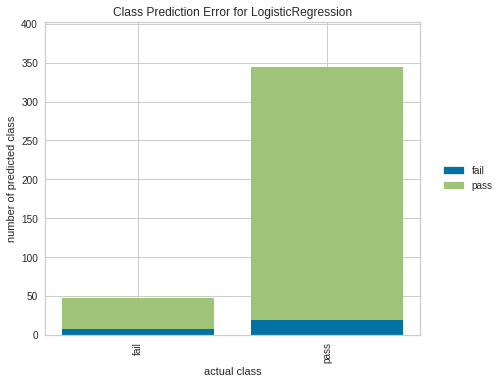

/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


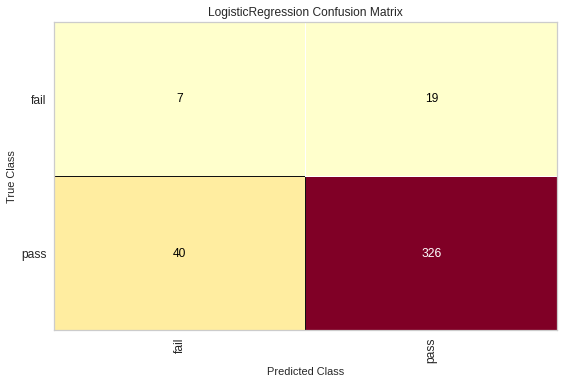

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


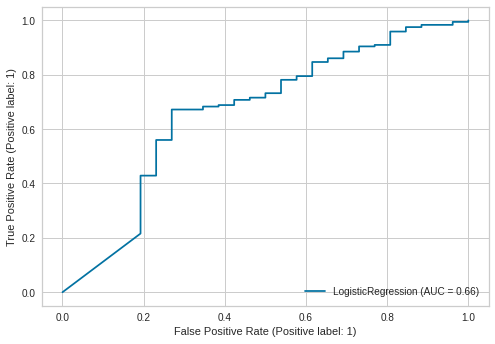

 Train time: 1018ms
 F1 Score: 0.8494897959183674
 MCC Score: 0.12252619848733756


In [18]:
# impute missing values and save it as a temporary dataset
imputer = KNNImputer()
imputer.fit(X_train_notime)
imputed_train = pd.DataFrame(imputer.transform(X_train_notime), columns = X_train_notime.columns)
imputed_test = pd.DataFrame(imputer.transform(X_test_notime), columns = X_test_notime.columns)

# lists to record time and scores
f1scores = []
mccscores = []
times = []

time, f1score, mccscore = evaluate(train_df= imputed_train, test_df= imputed_test, train_target= y_train, test_target= y_test)
print(f' Train time: {time}ms\n F1 Score: {f1score}\n MCC Score: {mccscore}')
f1scores.append(f1score)
mccscores.append(mccscore)
times.append(time)






# Feature Selection

# 1- Percent Missing Values

Getting rid of columns with more than 50% of missing data.

In [19]:
def percentna(dataframe, threshold):
  columns = dataframe.columns[(dataframe.isna().sum()/dataframe.shape[0]) > threshold]
  return columns.tolist()

In [20]:
na_columns = percentna(X_train, 0.5)
X_train_nona = X_train_notime.drop(na_columns, axis= 1)
X_test_nona = X_test_notime.drop(na_columns, axis= 1)
n_features1 = X_train_nona.shape[1]
print(f'After removing {len(na_columns)} features, there are {n_features1} features left.')

After removing 24 features, there are 566 features left.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


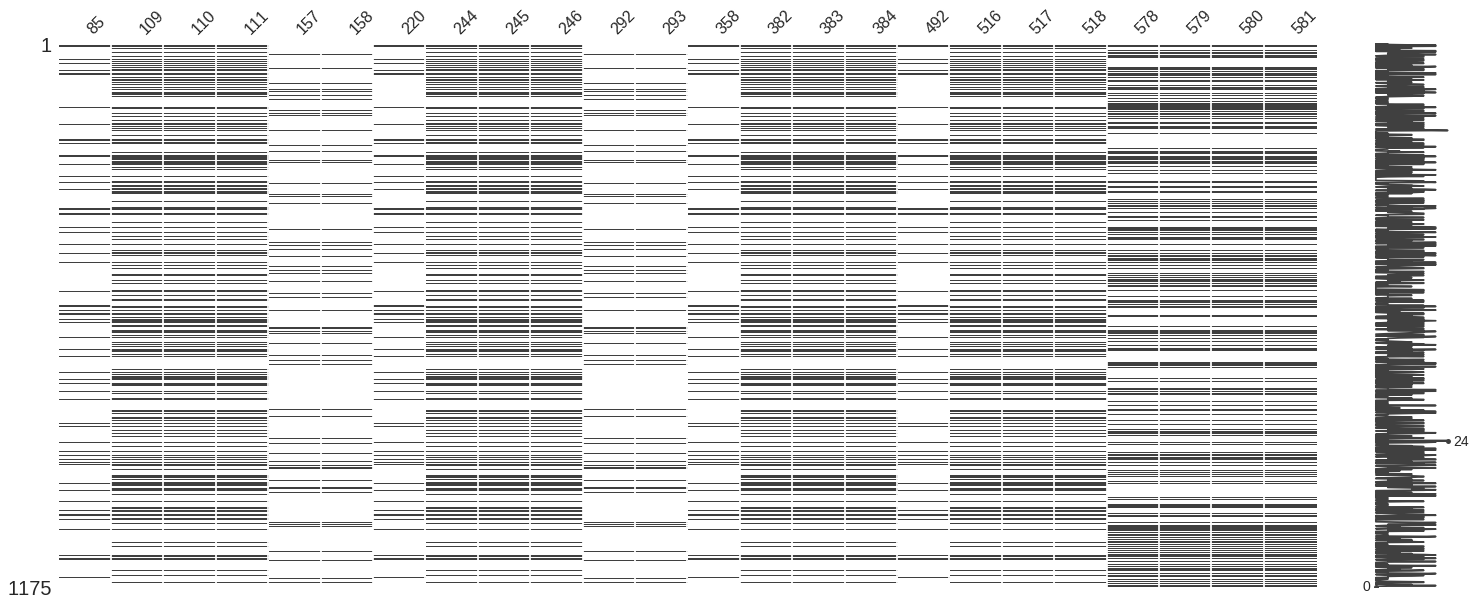

In [21]:
# install the package
! pip install missingno
import missingno as msno
msno.matrix(X_train_notime[na_columns])

# Impute Missing Values
- Use KNNImputer to impute missing values, here is how it works: <br/>
Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.

/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


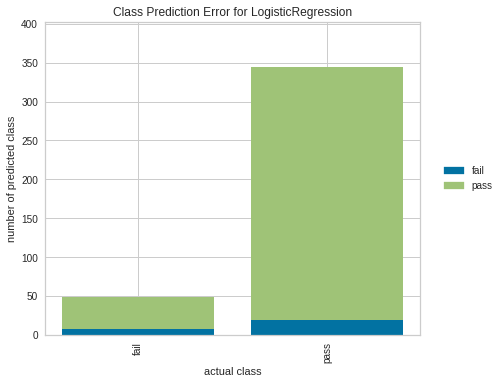

/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


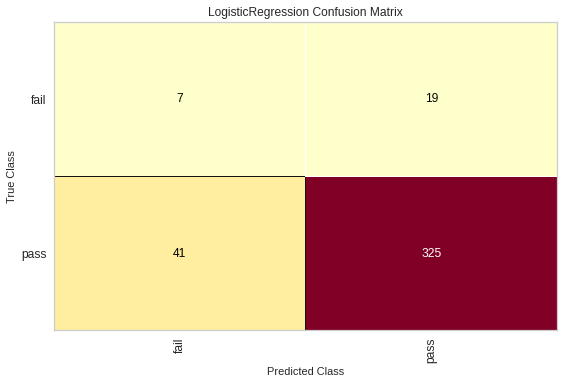

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


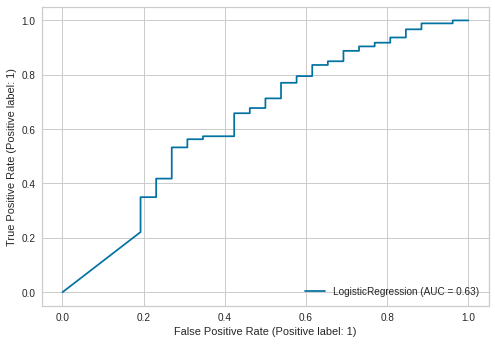

 Train time: 945ms
 F1 Score: 0.8469387755102041
 MCC Score: 0.11934508465710662


In [22]:
imputer = KNNImputer()
imputer.fit(X_train_nona)
X_train_imp = pd.DataFrame(imputer.transform(X_train_nona), columns = X_train_nona.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test_nona), columns = X_test_nona.columns)

# evalute
time, f1score, mccscore = evaluate(train_df= X_train_imp, test_df= X_test_imp, train_target= y_train, test_target= y_test)
print(f' Train time: {time}ms\n F1 Score: {f1score}\n MCC Score: {mccscore}')
f1scores.append(f1score)
mccscores.append(mccscore)
times.append(time)

# 2- Amount of Variation

This technique eliminates features that have a variation below a specified threshold. When a characteristic doesn't vary much within itself, it has low predictive potential, according to the theory.

In [23]:
normalizer = Normalizer()
normalizer.fit(X_train_imp)
X_train_nrm = pd.DataFrame(normalizer.transform(X_train_imp), columns= X_train_imp.columns)
X_test_nrm = pd.DataFrame(normalizer.transform(X_test_imp), columns= X_test_imp.columns)


In [24]:
selector = VarianceThreshold()
selector.fit(X_train_nrm)
mask = selector.get_support()
columns = X_train_nrm.columns
selected_cols = columns[mask]
n_features2 = len(selected_cols)
print(f'remaining features: {n_features2}')

remaining features: 454


/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


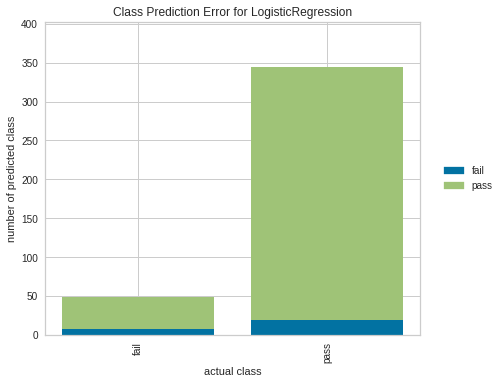

/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


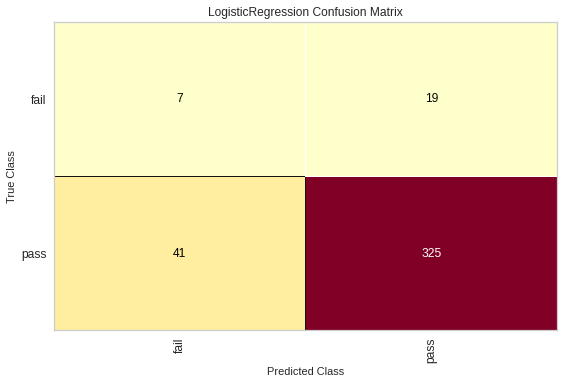

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


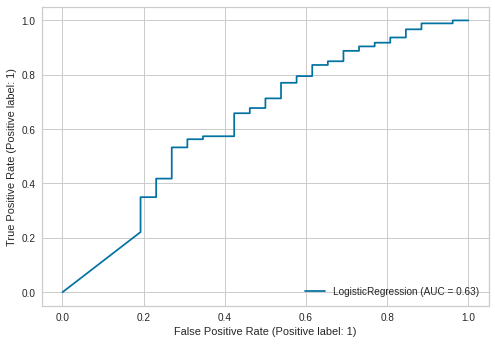

 Train time: 892ms
 F1 Score: 0.8469387755102041
 MCC Score: 0.11934508465710662


In [25]:
X_train_var = pd.DataFrame(selector.transform(X_train_imp), columns = selected_cols)
X_test_var = pd.DataFrame(selector.transform(X_test_imp), columns = selected_cols)

#evalute
time, f1score, mccscore = evaluate(train_df= X_train_var, test_df= X_test_var, train_target= y_train, test_target= y_test)
print(f' Train time: {time}ms\n F1 Score: {f1score}\n MCC Score: {mccscore}')
f1scores.append(f1score)
mccscores.append(mccscore)
times.append(time)

# 3- Pairwise Correlation

The correlation coefficient has values between -1 to 1

- A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
- A value closer to 1 implies stronger positive correlation
- A value closer to -1 implies stronger negative correlation

In [26]:
# create a function to select highly correlated features

def correlation(dataset, threshold):
  col_corr = set()
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i, j]) > threshold:
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr

In [27]:
corr_features = correlation(X_train_var, 0.95)
X_train_corr = X_train_var.drop(corr_features, axis=1)
X_test_corr = X_test_var.drop(corr_features, axis=1)
n_features3 = X_train_corr.shape[1]
print(f'After removing {len(corr_features)} features, there are {n_features3} features left.')

After removing 181 features, there are 273 features left.


/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


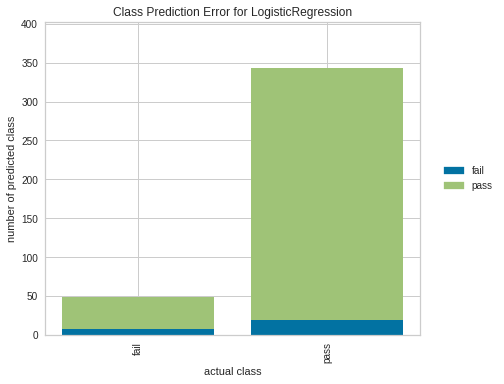

/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


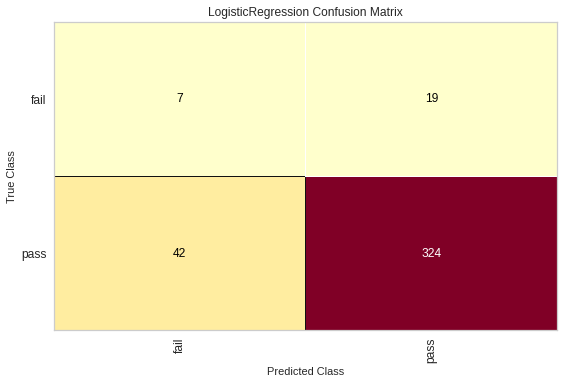

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


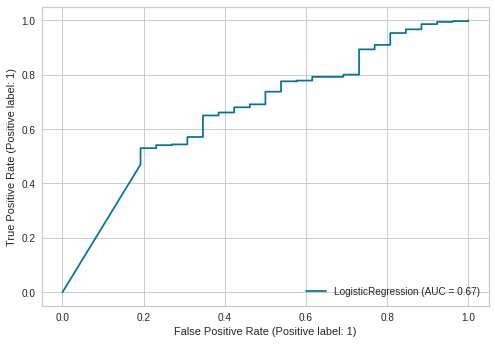

 Train time: 542ms
 F1 Score: 0.8443877551020407
 MCC Score: 0.1162371673985975


In [28]:
# evalute
time, f1score, mccscore = evaluate(train_df= X_train_corr, test_df= X_test_corr, train_target= y_train, test_target= y_test)
print(f' Train time: {time}ms\n F1 Score: {f1score}\n MCC Score: {mccscore}')
f1scores.append(f1score)
mccscores.append(mccscore)
times.append(time)

# 4- Correlation with Target
If a feature has low correlation with target, it means that it is not a helpful feature for predicting the target, and hence, should be removed.

In [29]:
# create a function to select low correlated features with target
def corrwith_target(dataframe, target, threshold):
  cor = dataframe.corr()
  cor_target = abs(cor[target])
  relevant_features = cor_target[cor_target < threshold]
  return relevant_features.index.tolist()[:-1]

In [30]:
dummy_train = X_train_corr.copy()
dummy_train['target'] = y_train

In [31]:
corrwith_cols = corrwith_target(dummy_train, 'target', 0.05)
X_train_corw = X_train_corr.drop(corrwith_cols, axis= 1)
X_test_corw = X_test_corr.drop(corrwith_cols, axis= 1)
n_features4 = X_train_corw.shape[1]
print(f'After removing {len(corrwith_cols)} features, there are {n_features4} features left.')



After removing 227 features, there are 46 features left.


/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


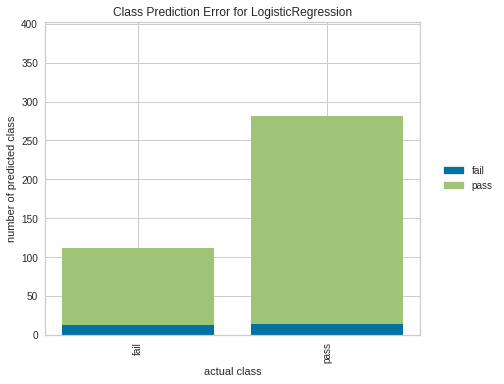

/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


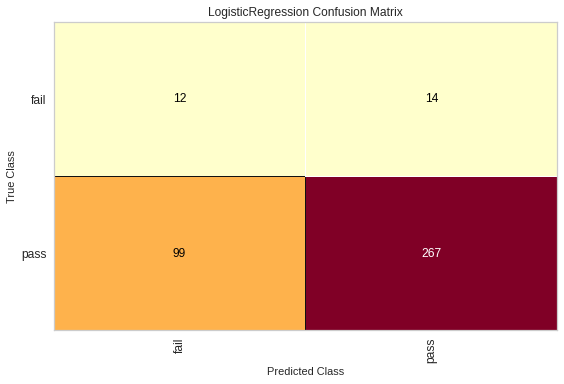

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


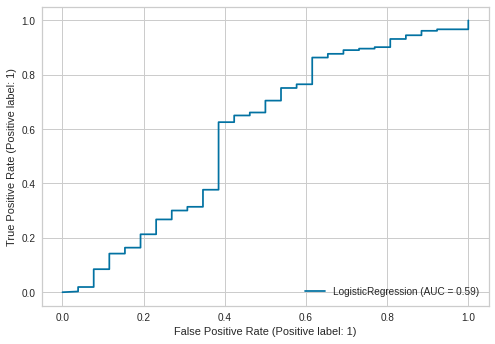

 Train time: 158ms
 F1 Score: 0.7117346938775511
 MCC Score: 0.1055241865126554


In [32]:
# evalute
time, f1score, mccscore = evaluate(train_df= X_train_corw, test_df= X_test_corw, train_target= y_train, test_target= y_test)
print(f' Train time: {time}ms\n F1 Score: {f1score}\n MCC Score: {mccscore}')
f1scores.append(f1score)
mccscores.append(mccscore)
times.append(time)

# 5- Recursive feature elimination
RFE starts with all of the features and then eliminates features one by one (based on their importance). it will stop when a certain number of features are left, or elimination of features no longer help the model.

In [33]:
scaler = StandardScaler()
scaler.fit(X_train_corw)
X_train_std = pd.DataFrame(scaler.transform(X_train_corw), columns=X_train_corw.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test_corw), columns=X_test_corw.columns)

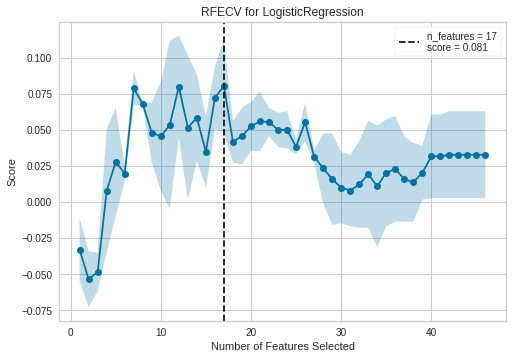

In [34]:
mcc_scorer = make_scorer(matthews_corrcoef)
rfecv = RFECV(estimator=LogisticRegression(random_state = 42, class_weight='balanced', C=200, dual=False, solver='liblinear'), cv = StratifiedKFold(2), scoring= mcc_scorer)
rfecv.fit(X_train_std, y_train.values.ravel())
rfecv.show()

In [35]:
mask = rfecv.get_support()
columns = X_train_corw.columns
selected_cols = columns[mask]
n_features5 = len(selected_cols)
X_train_rfe = pd.DataFrame(rfecv.transform(X_train_corw), columns= selected_cols)
X_test_rfe = pd.DataFrame(rfecv.transform(X_test_corw), columns= selected_cols)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(


/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


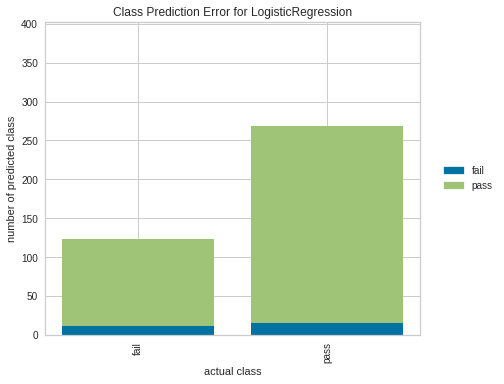

/usr/local/lib/python3.8/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


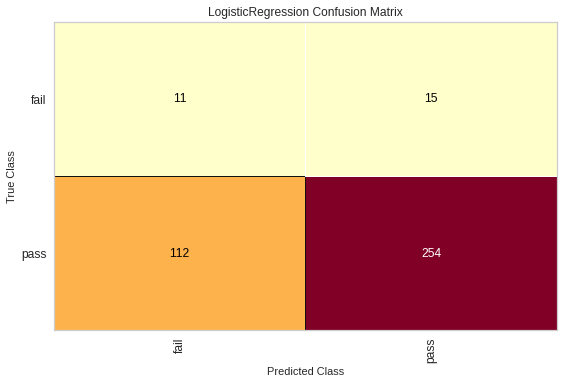

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


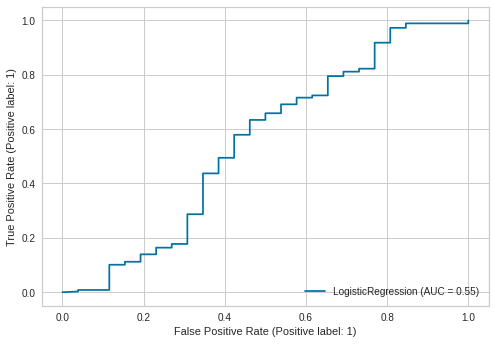

 Train time: 18ms
 F1 Score: 0.6760204081632653
 MCC Score: 0.06278115170068672


In [36]:
# evalute
time, f1score, mccscore = evaluate(train_df= X_train_rfe, test_df= X_test_rfe, train_target= y_train, test_target= y_test)
print(f' Train time: {time}ms\n F1 Score: {f1score}\n MCC Score: {mccscore}')
f1scores.append(f1score)
mccscores.append(mccscore)
times.append(time)

# How did we do?


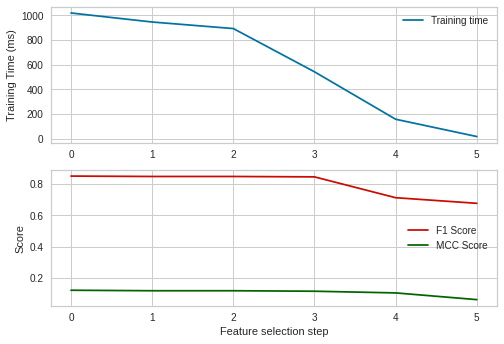

In [37]:
fig, (ax0, ax1) = plt.subplots(2, 1)
ax0.plot(times, label='Training time')
ax0.set(ylabel='Training Time (ms)')
ax1.plot(f1scores, label='F1 Score', c='r')
ax1.plot(mccscores, label='MCC Score', c='darkgreen')
ax1.set(ylabel='Score')
ax1.set(xlabel='Feature selection step')
ax1.legend()
ax0.legend()
fig.show()

as you can see, although the scores (specially, F1 score) have declined during feature selection, our training time has dropped drastically.

in scenarios where we have a lot of data, like in real world compaines, this is acceptable to lose a little accuracy and getting a huge boost in speed instead.

# Conclusion
Using the above steps we can do feature selection and reduce the features from about 600 to 17 features. There is a slight loss of information, while we have a huge boost in training speed.